# **Генерация подписей к изображениям**

## **Импорт библиотек и модулей**

In [2]:
import os
import re
import math
import requests
import pandas as pd
import random
import spacy
import torch
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim.lr_scheduler import LambdaLR

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##  **Загрузка, обработка и обзор данных**

Если работаем на google colab:

In [2]:
# !pip install -q kaggle
# !kaggle datasets download -d adityajn105/flickr8k
# !unzip -q /content/flickr8k.zip

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k

License(s): CC0-1.0


100% 1.04G/1.04G [00:46<00:00, 24.7MB/s]

100% 1.04G/1.04G [00:46<00:00, 23.8MB/s]


Укажем пути до изображений и подписей к ним.

In [3]:
imgs_path = "/kaggle/input/flickr8k/Images"
# imgs_path = "/content/Images"
captions_path = "/kaggle/input/flickr8k/captions.txt"
# captions_path = "/content/captions.txt"

Загрузим данные и выведем голову таблицы а также несколько строк описаний картинок.

In [4]:
captions_df = pd.read_csv(captions_path)
print('Shape of data:', captions_df.shape)
display(captions_df.head(3))
for i in range(1100, 1110):
    display(captions_df.caption[i])

Shape of data: (40455, 2)


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .

'A person drives in a red car .'

'A person in a red car , with a bridge in the background .'

'A person waits inside a red compact car .'

'A red car driving over a bridge .'

'The lady in the red car is crossing the bridge .'

'A girl with a black purse sitting on a wooden bench .'

'A woman sits alone on a park bench in the sun .'

'A woman with a handbag is sitting on a wooden bench .'

'A young asian woman wearing long shorts and a gray collared t-shirt is sitting on a wooden bench .'

'A young woman with a black purse sits on a wooden bench .'

Тексты описаний, разумеется, следует обработать, прежде чем собирать датасеты. Напишем функцию препроцессинга.

In [5]:
def text_preprocessing(data):
    # Удаляем из текстов описания все небуквенные символы
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    # Перевод текстов описаний в нижний регистр
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    # Удаление лишних пробелов
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'\s+', ' ', x))
    # Удаление пробелов в начале и конце строки
    data['caption'] = data['caption'].apply(lambda x: x.strip())
    return data

Скопируем датафрейм и проделаем все преобразования с текстом на копии, а затем выведем те же описания после обработки.

In [6]:
captions_df_copy = captions_df.copy()
captions_prprcssd = text_preprocessing(captions_df_copy)
for i in range(1100, 1110):
    display(captions_prprcssd.caption[i])

'a person drives in a red car'

'a person in a red car with a bridge in the background'

'a person waits inside a red compact car'

'a red car driving over a bridge'

'the lady in the red car is crossing the bridge'

'a girl with a black purse sitting on a wooden bench'

'a woman sits alone on a park bench in the sun'

'a woman with a handbag is sitting on a wooden bench'

'a young asian woman wearing long shorts and a gray collared tshirt is sitting on a wooden bench'

'a young woman with a black purse sits on a wooden bench'

Выберем случайные изображения и выведем напротив них все их подписи.

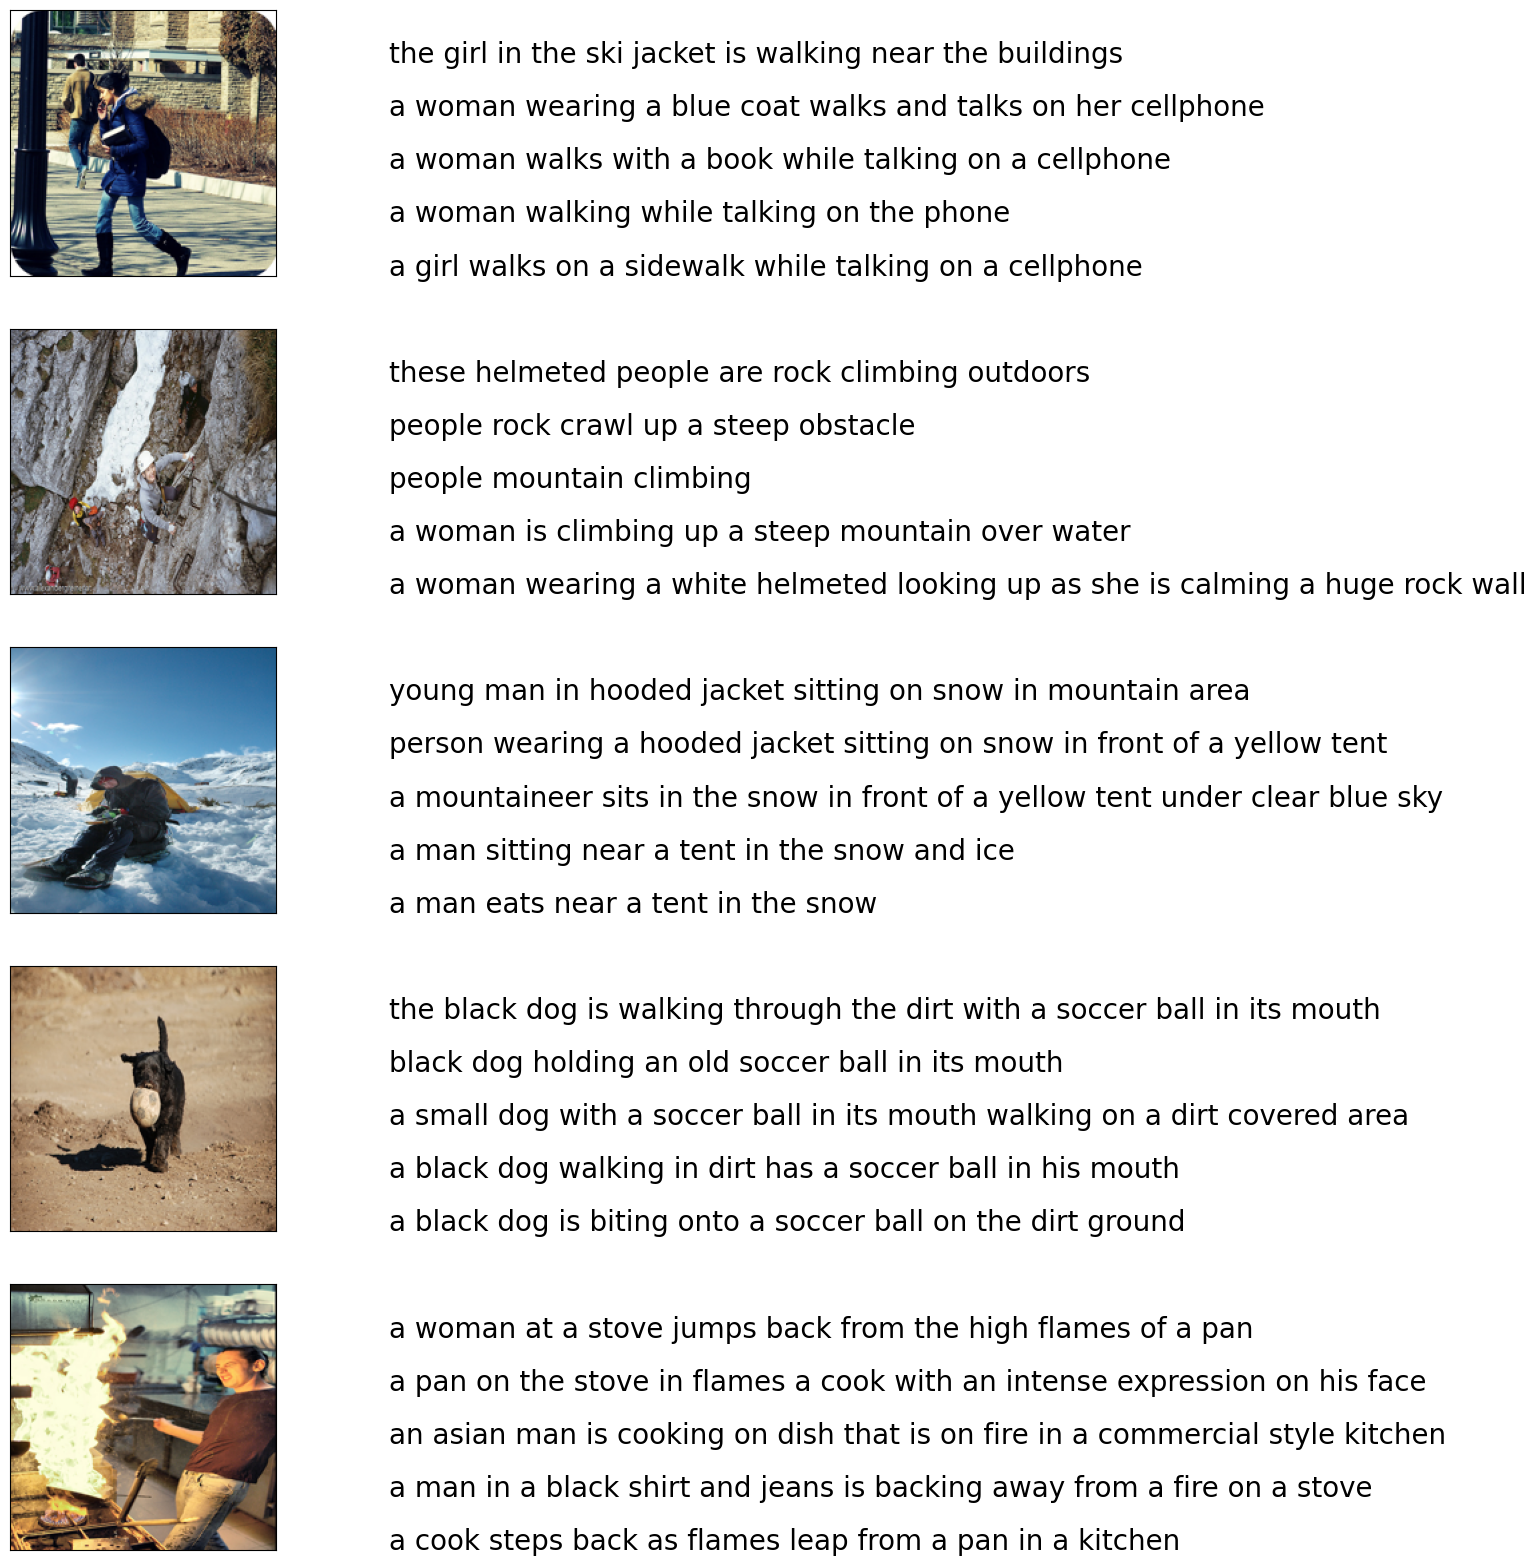

In [6]:
def visualaization(df, num_of_images):
    # Выбор случайных уникальных имен файлов
    unique_images = df['image'].unique()
    sampled_images = random.sample(list(unique_images), num_of_images)

    # Создание словаря подписей
    captions_dictionary = {}
    for image_id in sampled_images:
        captions = df[df['image'] == image_id]['caption'].tolist()
        captions_dictionary[image_id] = captions

    count = 1
    fig = plt.figure(figsize=(10, 20))
    for filename in captions_dictionary.keys():
        captions = captions_dictionary[filename]
        image_load = Image.open(os.path.join(imgs_path, filename)).resize((199, 199))

        ax = fig.add_subplot(num_of_images, 2, count, xticks=[], yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images, 2, count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(captions))
        for i, caption in enumerate(captions):
            ax.text(0, i, caption, fontsize=20)
        count += 1
    plt.show()


visualaization(captions_prprcssd, 5)

Также нелишним будет посмотреть на распределение описаний по числу слов в них.

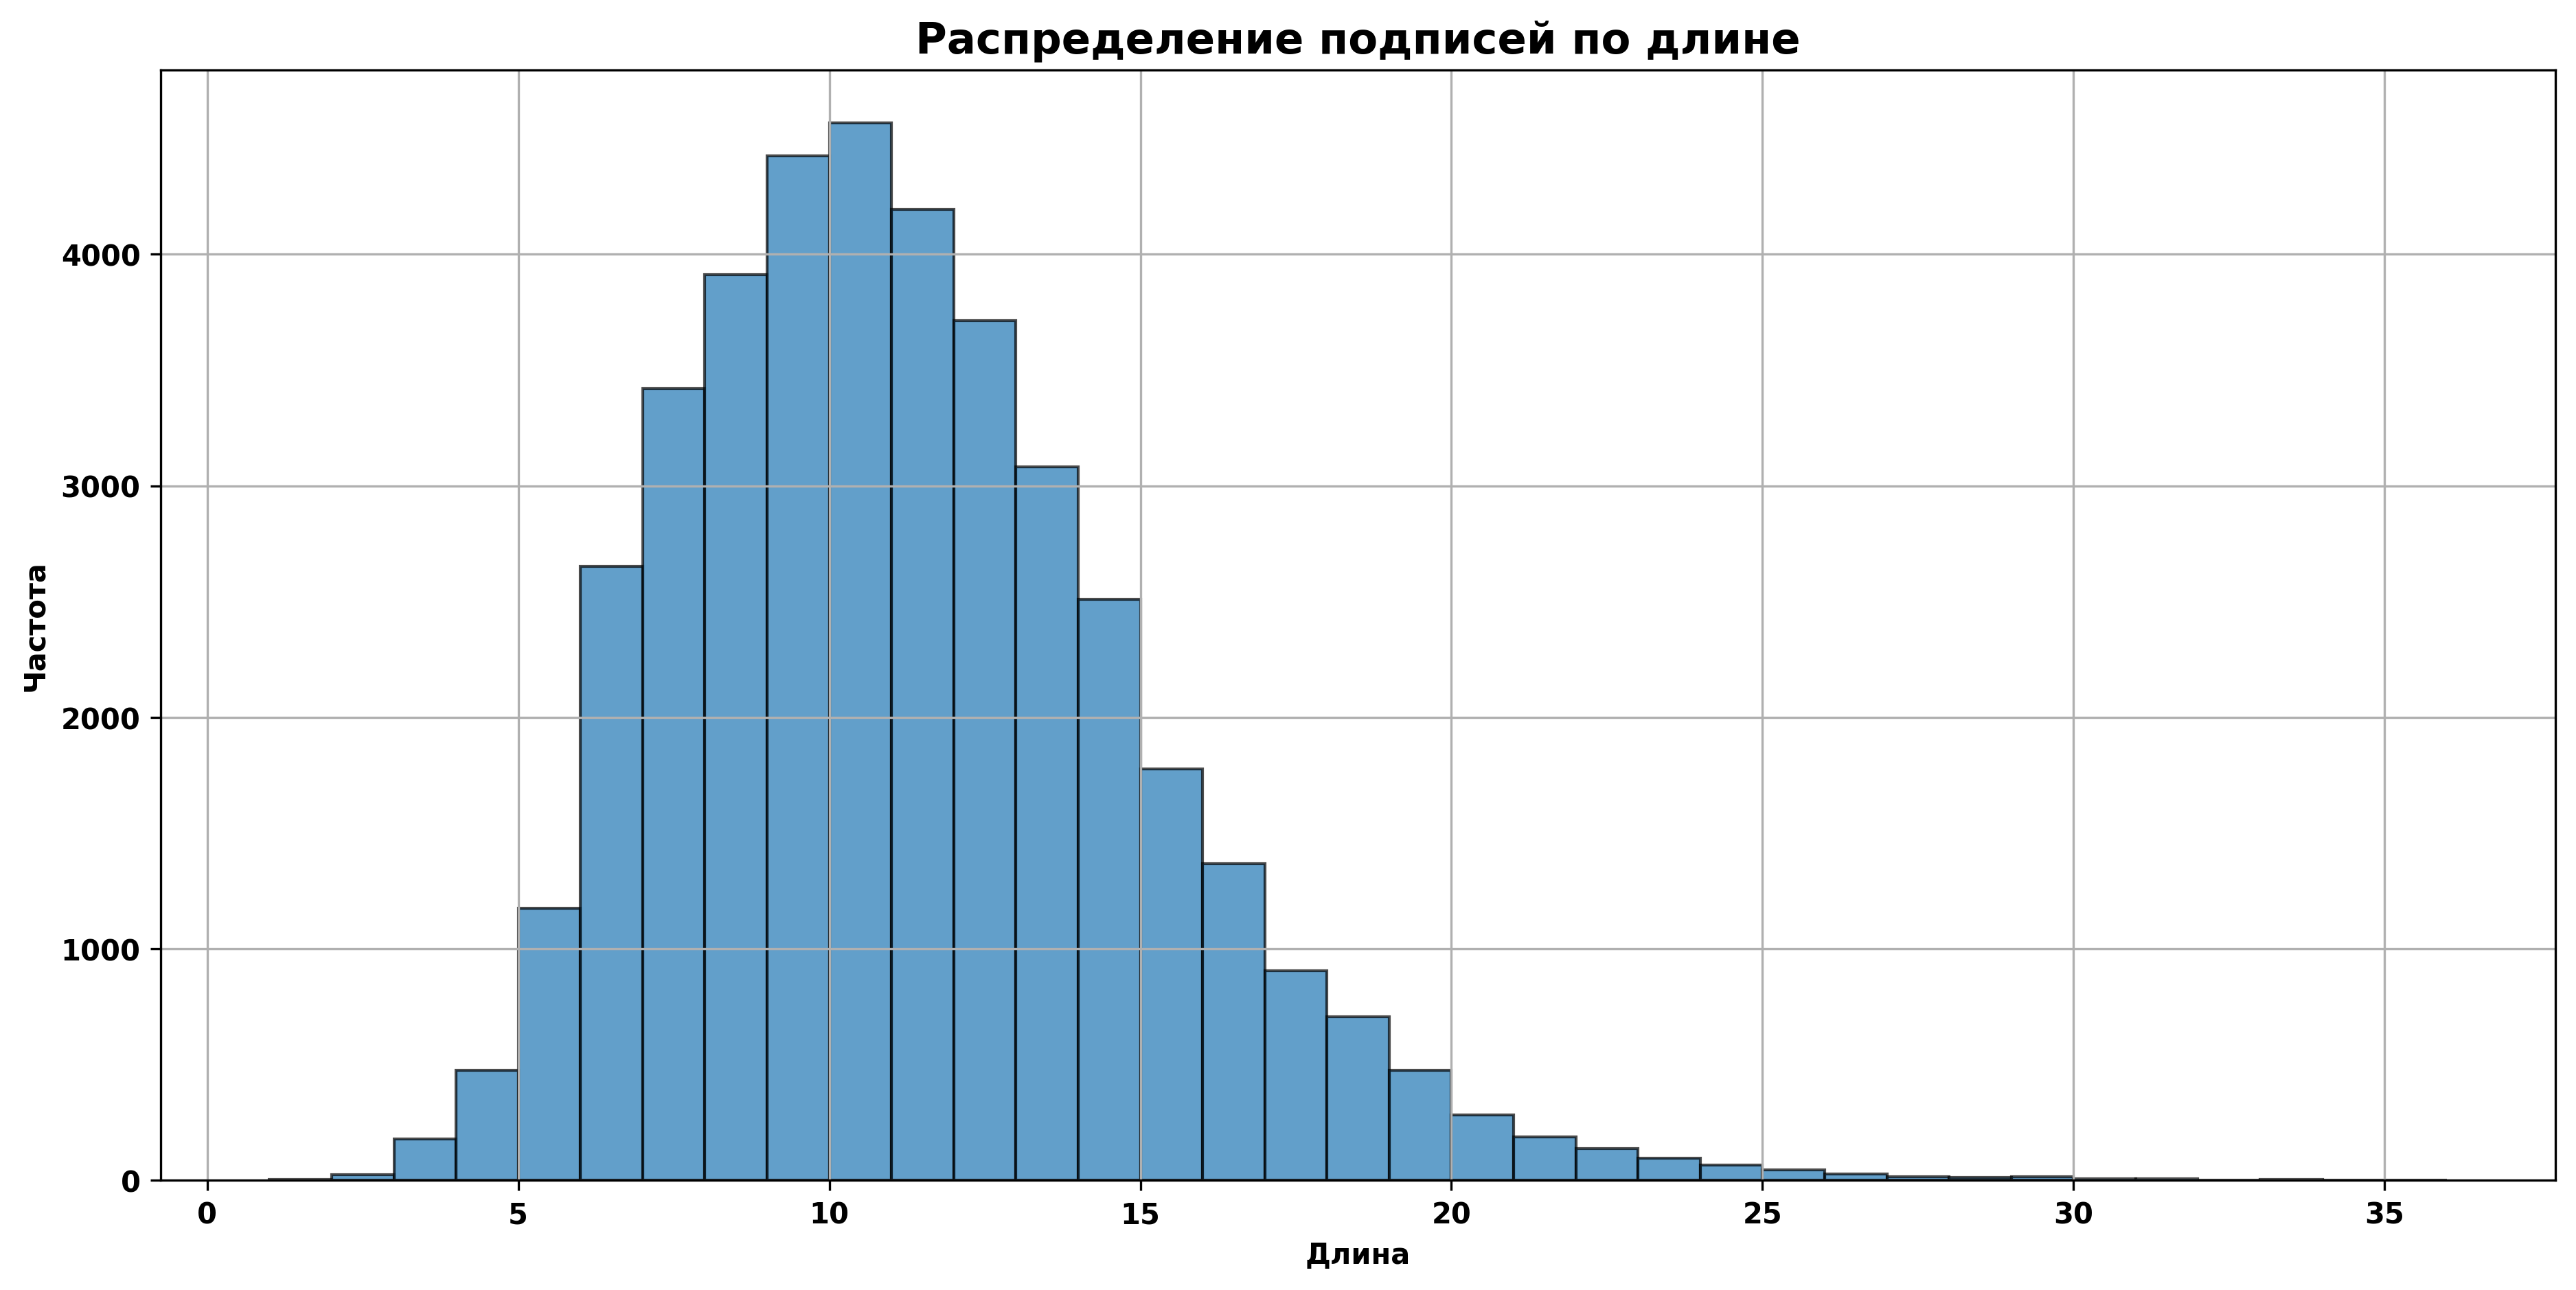

In [7]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    plt.hist(
        [len(x.split(' ')) for x in data],
        bins=range(1, max(len(x.split(' ')) for x in data) + 2),
        edgecolor='black', alpha=0.7
    )
    plt.title('Распределение подписей по длине', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Длина', fontweight='bold')
    plt.ylabel('Частота', fontweight='bold')
    plt.grid(True)
    plt.show()

captions_length(captions_prprcssd.caption.tolist())

Максимальная длина предложений может быть более 35 слов, тогда как чаще всего предложения имеют длину в 10-12.

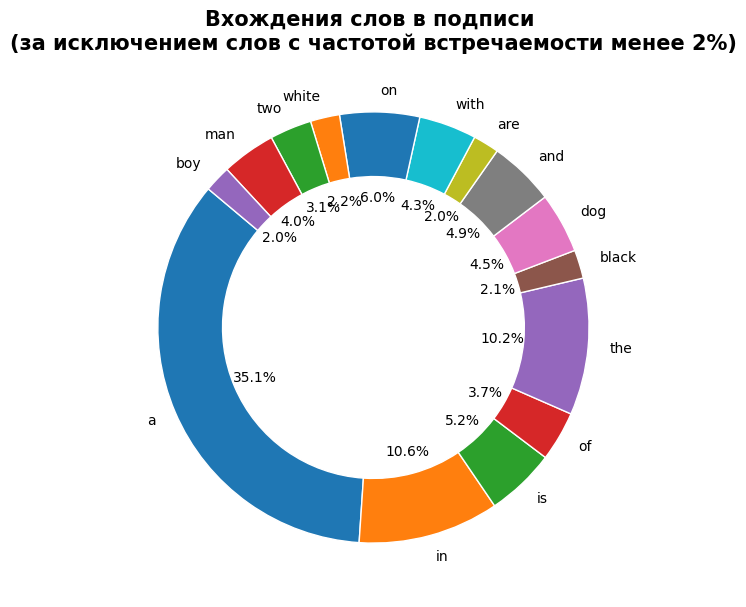

In [8]:
def word_occurrences(data):
    # Объединение всех предложений в одну строку
    all_text = ' '.join(data)
    # Разделение текста на слова и подсчет их частоты
    word_counts = Counter(all_text.split())

    # Фильтрация слов, доля которых менее 1 процента
    total_words = sum(word_counts.values())
    filtered_word_counts = {
        word: count for word,
        count in word_counts.items() if count / total_words >= 0.008
    }

    words = list(filtered_word_counts.keys())
    values = list(filtered_word_counts.values())

    # Построение круговой диаграммы
    plt.figure(figsize=(10, 7))
    plt.pie(
        values, labels=words, autopct='%1.1f%%',
        startangle=140, wedgeprops=dict(width=0.3, edgecolor='w')
    )
    plt.title('Вхождения слов в подписи \n(за исключением слов с частотой встречаемости менее 2%)', fontsize=15, fontweight='bold')
    plt.show()


word_occurrences(captions_prprcssd.caption.tolist())

Здесь возникает повод подумать над тем, не выкинуть ли из текстов артикль "a": он не несет в себе особенную смысловую нагрузку, но встречается очень часто. Однако если мы сделаем это, то нейронка будет генерировать непривычные предложения.

## **Формирование словаря, датасетов и загрузчиков**

### Признаки изображений и эмбэддинги слов

Чтобы обучать нейронки на текстах, их следует преобразовать в числовые значения и представить в матричном виде, а для этого нам потребуется:
1. Словарь, сопоставляющий каждое слово индексу и наоборот.
2. Настроить набор данных для загрузки данных.
3. Настроить форму данных в батчах для единообразия: все предложения должны быть одной длины внутри пакетов.

Но, т.к. мы решаем задачу генерации описаний для картинок, то нам необходимо также преобразовать изображения и представить их в векторной форме.

In [7]:
def preprocess_image(image):
    preprocess = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
    ])
    img = preprocess(image).unsqueeze(0)
    return img


def extract_image_features(model, image, device):
    img = preprocess_image(image).to(device)
    model.eval()
    with torch.no_grad():
        features = model(img)
    return features


def extract_features_from_dataframe(df, model, imgs_dir=imgs_path, device=device):
    """
    Функция для извлечения признаков изображений из датафрейма.

    Параметры:
    df (pd.DataFrame): Датафрейм с колонками "image" и "caption".
    model (torch.nn.Module): Модель для извлечения признаков изображений.
    images_dir (str): Путь к директории с изображениями.
    device (torch.device): Устройство ("cpu" или "cuda").

    Возвращает:
    dict: Словарь, где ключи - имена файлов изображений,
    значения - извлеченные тензоры признаков.
    """
    image_features_dict = {}

    unique_images = df['image'].unique()

    for image_id in tqdm(unique_images, desc="Extracting features"):
        image_path = os.path.join(imgs_dir, image_id)
        img = Image.open(image_path).convert("RGB")
        image_features = extract_image_features(model, img, device)
        image_features_dict[image_id] = image_features.flatten().cpu()

    return image_features_dict

In [8]:
# Назначаем экстрактор признаков
ftrs_extrctr = models.inception_v3(weights='IMAGENET1K_V1')
# Убираем fc-слой imagenet-классификатора
ftrs_extrctr.fc = torch.nn.Identity()
ftrs_extrctr = ftrs_extrctr.to(device)

# Получаем словарь с фичами изображений
imgs_ftrs_dict = extract_features_from_dataframe(captions_prprcssd, ftrs_extrctr)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 170MB/s] 
Extracting features: 100%|██████████| 8091/8091 [04:37<00:00, 29.14it/s]


In [9]:
# Сохранение словаря с тензорами
torch.save(imgs_ftrs_dict, 'imgs_ftrs_dict.pt')

# Загрузка словаря из файла
loaded_imgs_ftrs_dict = torch.load('imgs_ftrs_dict.pt')

### Токенезация предложений

Токенезация предшествует векторизации и состоит в том, что текст разбивается на смысловые части, для которых в дальнейшем и строится векторное представление на основе индексов значений словаря.

Помимо частей самого текста, используют специальные токены:

* `PAD` — токен выравнивания предложений: если предложение больше установленной длины, слова обрезаются, если меньше — в конец предложения добавляется pad до заполнения.

* `SOS` — "start of sentence" то же, что и <start> на картинке ниже — первый токен, который подается в декодер вместе с вектором, чтобы начать генерировать токены ответа.
    
* `EOS` — "end of sentence" — то же, что и <end> на картинке ниже — как только декодер сгенерирует этот токен, мы считаем ответ полным (обычные знаки препинания для этой цели использовать нельзя, так как их значениея могут быть разные).

* `UNK` — "unknown" — используется для замены редких слов, которые не вошли в словарь. Например, предложение «Меня зовут guotong1999» будет переведено на «Меня зовут UNK».

<img src='https://cloud.githubusercontent.com/assets/2272790/18410099/1d0a1c1a-7761-11e6-9fe1-bd2e5622b90a.png'>

In [10]:
spacy_eng = spacy.load("en_core_web_sm")

In [11]:
# Создание словаря
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

    def decode(self, tensor):
        words = [self.itos[idx.item()] for idx in tensor]
        return ' '.join(words)

In [12]:
# Создание единого словаря
Flickr_vocab = Vocabulary(freq_threshold=5)
Flickr_vocab.build_vocabulary(captions_df['caption'].tolist())

In [13]:
# Все имена изображений
all_images_names = captions_prprcssd.image.unique().tolist()

# Сплитуем коллекцию
train_images, valid_images = train_test_split(all_images_names, test_size=0.1, random_state=42)
valid_images, test_images = train_test_split(valid_images, test_size=0.1, random_state=42)

# Сортировка строк таблицы на основе списков имен
train_df = captions_prprcssd[captions_prprcssd['image'].isin(train_images)]
valid_df = captions_prprcssd[captions_prprcssd['image'].isin(valid_images)]
test_df = captions_prprcssd[captions_prprcssd['image'].isin(test_images)]

print('Train data captions:', train_df.shape[0],
    '\nUnique imgs num:', len(train_df.image.unique()))
print('Valid data captions:', valid_df.shape[0],
      '\nUnique imgs num:', len(valid_df.image.unique()))
print('Test data captions: ', test_df.shape[0],
      '\nUnique imgs num:', len(test_df.image.unique()))

Train data captions: 36405 
Unique imgs num: 7281
Valid data captions: 3645 
Unique imgs num: 729
Test data captions:  405 
Unique imgs num: 81


In [14]:
# Класс для датасета Flickr
class FlickrDataset(Dataset):
    def __init__(self, df_set, ftrs_dict, vocab=Flickr_vocab, img_size=(360, 360)):
        self.df = df_set
        self.ftrs_dict = ftrs_dict
        self.vocab = vocab
        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name, caption = self.df.iloc[index]

        # Преобразование изображения в тензор
        img = Image.open(os.path.join(imgs_path, img_name)).convert("RGB")
        img = self.transform(img)

        # Извлечение признаков изображения из словаря
        img_ftrs = self.ftrs_dict[img_name]

        # Преобразование текста в числовую последовательность
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, img_ftrs, torch.tensor(numericalized_caption)


# Класс для приведения описаний и эмбеддингов к общему виду
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        # Извлекаем изображения и добавляем новое измерение для каждого изображения
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)

        # Извлекаем признаки изображений
        features = [item[1].unsqueeze(0) for item in batch]
        features = torch.cat(features, dim=0)

        # Извлекаем описания изображений
        descriptions = [item[2] for item in batch]
        descriptions = pad_sequence(descriptions, batch_first=False, padding_value=self.pad_idx)

        return imgs, features, descriptions


# Функция для создания DataLoader
def get_loader(
    df_set, ftrs_dict, batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=True, pin_memory=True,
):
    dataset = FlickrDataset(df_set, ftrs_dict)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

Произведем непосредственную сборку датасетов и загрузчиков.

In [15]:
train_loader, train_dataset = get_loader(train_df, loaded_imgs_ftrs_dict)
valid_loader, valid_dataset = get_loader(valid_df, loaded_imgs_ftrs_dict, shuffle=False)
test_loader, test_dataset = get_loader(test_df, loaded_imgs_ftrs_dict, shuffle=False)

print('done!')

done!


In [16]:
def check_loader_size(loader):
    num_batches = len(loader)
    batch_size = loader.batch_size
    print(f'Number of batches: {num_batches}')
    print(f'Batch size: {batch_size}')

    # Проверка размера первого батча
    first_batch = next(iter(loader))
    imgs, ftrs, captions = first_batch
    print(f'Size of first batch of images: {imgs.size()}')
    print(f'Size of first batch of ftrs: {ftrs.size()}')
    print(f'Size of first batch of captions: {captions.size()}')


# Проверим состав и форму данных
check_loader_size(train_loader)
check_loader_size(valid_loader)
check_loader_size(test_loader)

Number of batches: 1138
Batch size: 32
Size of first batch of images: torch.Size([32, 3, 360, 360])
Size of first batch of ftrs: torch.Size([32, 2048])
Size of first batch of captions: torch.Size([21, 32])
Number of batches: 114
Batch size: 32
Size of first batch of images: torch.Size([32, 3, 360, 360])
Size of first batch of ftrs: torch.Size([32, 2048])
Size of first batch of captions: torch.Size([25, 32])
Number of batches: 13
Batch size: 32
Size of first batch of images: torch.Size([32, 3, 360, 360])
Size of first batch of ftrs: torch.Size([32, 2048])
Size of first batch of captions: torch.Size([20, 32])


Посмотрим на случайное изображение из датасета и его подпись.

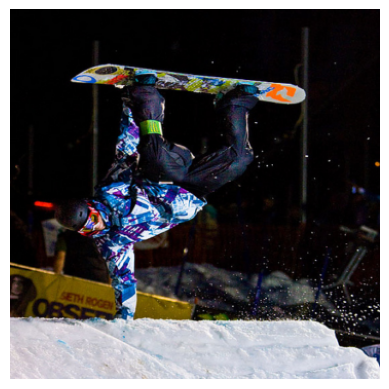

case idx: 26460

caption:

<SOS> a snowboarder balancing on his hand with the snowboard in the air <EOS>


In [ ]:
# Случайно выбираем индекс
random_index = random.randint(0, len(train_dataset) - 1)

# Получаем изображение и подпись
img, _, caption = train_dataset[random_index]

# Преобразуем тензор изображения обратно в numpy массив для отображения
img = img.permute(1, 2, 0).numpy()
img = ((img - img.min()) / (img.max() - img.min()) * 255).astype('uint8')

# Декодируем подпись
caption_words = [train_dataset.vocab.itos[idx.item()] for idx in caption]
caption_text = ' '.join(caption_words)

# Отображаем изображение и подпись
plt.imshow(img)
plt.axis('off')
plt.show()

print(
    f'case idx: {random_index}',
    f'caption:\n{caption_text}',
    sep='\n'
)

Посмотрим на данные, выдаваемые загрузчиком:

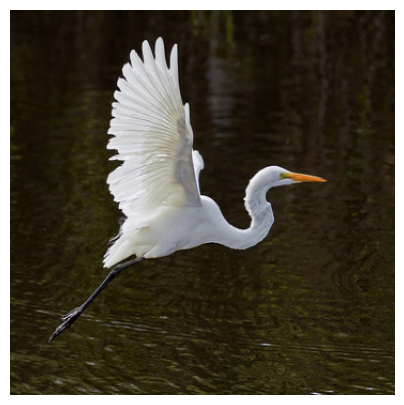

tensor([  1,   4,   3, 697, 648,  39,   9,  43,   2,   0,   0,   0,   0,   0,

          0,   0])

<SOS> a <UNK> flying low over the water <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [ ]:
def visualize_random_pair_from_dataloader(dataloader):
    """
    Визуализирует одно случайное изображение и выводит его описание
    из DataLoader в тензорном виде и расшифровку последнего по словарю.

    :param dataloader: DataLoader, содержащий батчи изображений и описаний.
    """
    batch = next(iter(dataloader))
    images, _, descriptions = batch
    idx = random.randint(0, len(images) - 1)
    img = images[idx]
    desc = descriptions.T[idx]

    plt.figure(figsize=(5, 5))
    img = img.permute(1, 2, 0).numpy()
    img = ((img - img.min()) / (img.max() - img.min()) * 255).astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(desc)

    # Переводим тензор в словесную форму
    vocab = dataloader.dataset.vocab
    description_text = vocab.decode(desc)
    print(description_text)


visualize_random_pair_from_dataloader(train_loader)

Все специальные токены — на своих местах.

## **Модель**

Простые модели генерации подписей к изображениям состоят обычно из кодировщика и декодера. Кодировщиком выступает какая-нибудь предобученная (на ImageNet, например) сеть с замененной головой-класификатором на иной полносвязный слой. А декодером выступает RNN-сеть (LSTM/GRU также можно использовать). Более сложные решения включают механизмы внимания и трансформеры в декодирующем блоке.

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

In [17]:
class ImageCaptioningModel(nn.Module):
    def __init__(
        self, vocab_size, embed_size, hidden_size,
        max_caption_length, cnn_output_dim):
        super(ImageCaptioningModel, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        # Encoder layers
        self.encoder_dense = nn.Linear(cnn_output_dim, embed_size)
        # Decoder layers
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size)
        # Output layers
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, ftrs, captions):
        ftrs_encoded = self.relu(self.encoder_dense(ftrs)).unsqueeze(0)
        embedded_captions = self.embedding(captions)
        combined = torch.cat((ftrs_encoded, embedded_captions), dim=0)
        hiddens, _ = self.lstm(combined)
        x = self.fc1(self.dropout(hiddens))
        x = self.dropout(self.relu(x))
        output = self.fc2(x)
        return output

    def caption_image(self, image_ftrs, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoder_dense(image_ftrs).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.lstm(x, states)
                output = self.fc2(self.relu(self.fc1(hiddens.squeeze(0))))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.embedding(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

In [25]:
def visualizer(model, dataset, device, vocab):
    model.eval()
    with torch.no_grad():
        # Выбираем случайное изображение из валидационного набора
        img, ftrs, caption = random.choice(dataset)
        ftrs = ftrs.unsqueeze(0).to(device)

        # Генерируем подпись
        generated_caption = model.caption_image(ftrs, vocab)
        decoded_caption = " ".join(generated_caption)

        # Визуализируем изображение и его подпись
        img = img.cpu().numpy().transpose(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min())

        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        print('predict:', decoded_caption)
        caption_words = [dataset.vocab.itos[idx.item()] for idx in caption]
        print(f'true: {" ".join(caption_words)}')

## **Обучение модели**

In [26]:
# torch.backends.cudnn.benchmark = True

# Гиперпараметры
embed_size = 1024
hidden_size = 512
vocab_size = len(train_dataset.vocab)
max_caption_length = 50
cnn_output_dim = 2048
batch_size_train = 32
batch_size_val = 16
learning_rate = 1e-4
num_epochs = 30
rep_freq = 3
# Параметры ранней остановки
early_stopping_patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Определение функции lr-планировщика
def lr_scheduler_lambda(epoch):
    return math.exp(-0.6 * epoch)

# Инициализация модели
model = ImageCaptioningModel(
    vocab_size, embed_size, hidden_size,
    max_caption_length, cnn_output_dim
).to(device)

# Инициализация функции ошибки
criterion = nn.CrossEntropyLoss(
    ignore_index=train_dataset.vocab.stoi["<PAD>"]
)

# Инициализация оптимизатора
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-4
)

# Инициализация lr-планировщика
# scheduler = LambdaLR(optimizer, lr_lambda=lr_scheduler_lambda)

100%|██████████| 1138/1138 [02:25<00:00,  7.82it/s]

Epoch [1/30], avg train loss: 4.1105



100%|██████████| 114/114 [00:15<00:00,  7.48it/s]


Epoch [1/30], avg valid loss: 3.4591
Inference on test dataset:


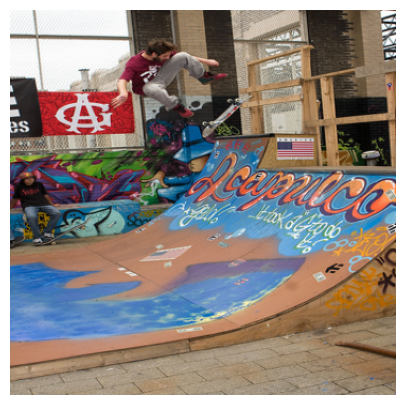

predict: <SOS> a man in a red shirt is running through the water <EOS>
true: <SOS> a skateboarder on a ramp <EOS>


100%|██████████| 1138/1138 [02:27<00:00,  7.73it/s]

Epoch [2/30], avg train loss: 3.4265



100%|██████████| 114/114 [00:15<00:00,  7.55it/s]

Epoch [2/30], avg valid loss: 3.1912



100%|██████████| 1138/1138 [02:22<00:00,  7.97it/s]

Epoch [3/30], avg train loss: 3.2145



100%|██████████| 114/114 [00:15<00:00,  7.45it/s]


Epoch [3/30], avg valid loss: 3.0348
Inference on test dataset:


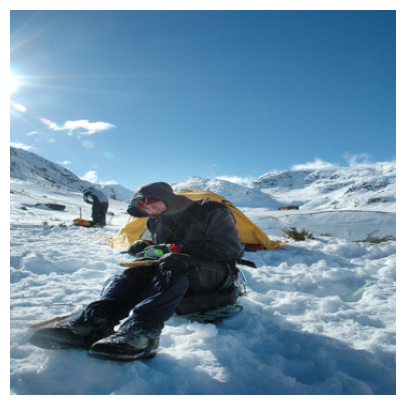

predict: <SOS> a man in a red shirt is standing on a beach <EOS>
true: <SOS> a man sitting near a tent in the snow and ice <EOS>


100%|██████████| 1138/1138 [02:27<00:00,  7.73it/s]

Epoch [4/30], avg train loss: 3.0732



100%|██████████| 114/114 [00:15<00:00,  7.51it/s]

Epoch [4/30], avg valid loss: 2.9369



100%|██████████| 1138/1138 [02:27<00:00,  7.73it/s]

Epoch [5/30], avg train loss: 2.9710



100%|██████████| 114/114 [00:15<00:00,  7.47it/s]


Epoch [5/30], avg valid loss: 2.8634


100%|██████████| 1138/1138 [02:24<00:00,  7.87it/s]

Epoch [6/30], avg train loss: 2.8920



100%|██████████| 114/114 [00:16<00:00,  6.86it/s]


Epoch [6/30], avg valid loss: 2.8080
Inference on test dataset:


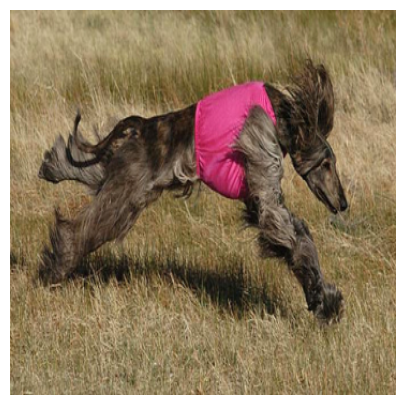

predict: <SOS> a black dog is running through the grass <EOS>
true: <SOS> a brown dog in a pink shirt runs through a field <EOS>


100%|██████████| 1138/1138 [02:29<00:00,  7.60it/s]

Epoch [7/30], avg train loss: 2.8269



100%|██████████| 114/114 [00:14<00:00,  7.65it/s]

Epoch [7/30], avg valid loss: 2.7614



100%|██████████| 1138/1138 [02:27<00:00,  7.73it/s]

Epoch [8/30], avg train loss: 2.7740



100%|██████████| 114/114 [00:14<00:00,  7.69it/s]


Epoch [8/30], avg valid loss: 2.7317


100%|██████████| 1138/1138 [02:28<00:00,  7.67it/s]

Epoch [9/30], avg train loss: 2.7272



100%|██████████| 114/114 [00:14<00:00,  7.81it/s]


Epoch [9/30], avg valid loss: 2.7042
Inference on test dataset:


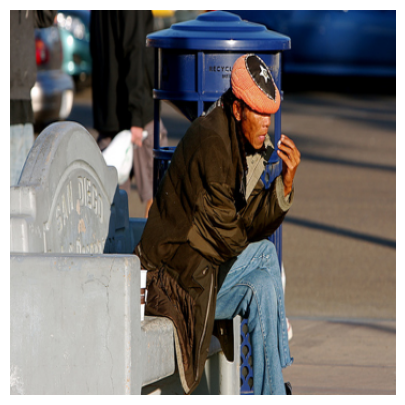

predict: <SOS> a man in a black shirt is sitting on a bench <EOS>
true: <SOS> a man sits on a bench on a <UNK> <UNK> street <EOS>


100%|██████████| 1138/1138 [02:26<00:00,  7.78it/s]

Epoch [10/30], avg train loss: 2.6873



100%|██████████| 114/114 [00:14<00:00,  7.82it/s]

Epoch [10/30], avg valid loss: 2.6860



100%|██████████| 1138/1138 [02:22<00:00,  7.97it/s]

Epoch [11/30], avg train loss: 2.6528



100%|██████████| 114/114 [00:14<00:00,  7.87it/s]

Epoch [11/30], avg valid loss: 2.6703



100%|██████████| 1138/1138 [02:21<00:00,  8.06it/s]

Epoch [12/30], avg train loss: 2.6201



100%|██████████| 114/114 [00:14<00:00,  7.88it/s]


Epoch [12/30], avg valid loss: 2.6522
Inference on test dataset:


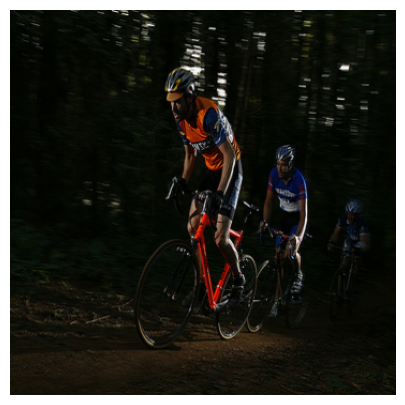

predict: <SOS> a man in a red helmet rides a bike <EOS>
true: <SOS> man with red shirt on a red bike in front of two other people on bikes <EOS>


100%|██████████| 1138/1138 [02:23<00:00,  7.91it/s]

Epoch [13/30], avg train loss: 2.5911



100%|██████████| 114/114 [00:14<00:00,  7.78it/s]

Epoch [13/30], avg valid loss: 2.6412



100%|██████████| 1138/1138 [02:25<00:00,  7.82it/s]

Epoch [14/30], avg train loss: 2.5647



100%|██████████| 114/114 [00:14<00:00,  7.74it/s]

Epoch [14/30], avg valid loss: 2.6362



100%|██████████| 1138/1138 [02:23<00:00,  7.93it/s]

Epoch [15/30], avg train loss: 2.5389



100%|██████████| 114/114 [00:14<00:00,  7.67it/s]


Epoch [15/30], avg valid loss: 2.6233
Inference on test dataset:


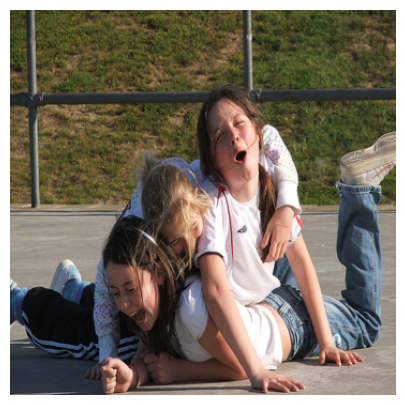

predict: <SOS> two girls are sitting on a bench <EOS>
true: <SOS> three girls pile on top of each other on the concrete <EOS>


100%|██████████| 1138/1138 [02:24<00:00,  7.85it/s]

Epoch [16/30], avg train loss: 2.5138



100%|██████████| 114/114 [00:15<00:00,  7.58it/s]

Epoch [16/30], avg valid loss: 2.6249



100%|██████████| 1138/1138 [02:26<00:00,  7.78it/s]

Epoch [17/30], avg train loss: 2.4910



100%|██████████| 114/114 [00:15<00:00,  7.56it/s]

Epoch [17/30], avg valid loss: 2.6228



100%|██████████| 1138/1138 [02:26<00:00,  7.74it/s]

Epoch [18/30], avg train loss: 2.4690



100%|██████████| 114/114 [00:14<00:00,  7.81it/s]


Epoch [18/30], avg valid loss: 2.6206
Inference on test dataset:


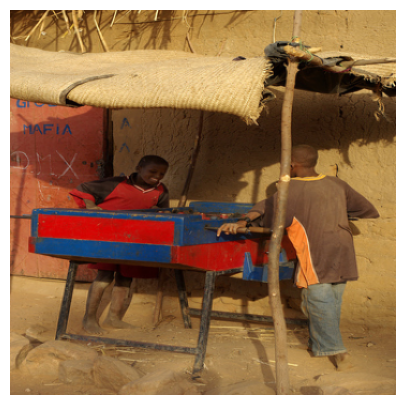

predict: <SOS> a boy is sitting on a wooden bench <EOS>
true: <SOS> two men play a game beneath a shade <EOS>


100%|██████████| 1138/1138 [02:25<00:00,  7.80it/s]

Epoch [19/30], avg train loss: 2.4478



100%|██████████| 114/114 [00:14<00:00,  7.95it/s]

Epoch [19/30], avg valid loss: 2.6151



100%|██████████| 1138/1138 [02:24<00:00,  7.89it/s]

Epoch [20/30], avg train loss: 2.4278



100%|██████████| 114/114 [00:14<00:00,  7.77it/s]

Epoch [20/30], avg valid loss: 2.6139



100%|██████████| 1138/1138 [02:24<00:00,  7.87it/s]

Epoch [21/30], avg train loss: 2.4105



100%|██████████| 114/114 [00:14<00:00,  7.85it/s]


Epoch [21/30], avg valid loss: 2.6211
Inference on test dataset:


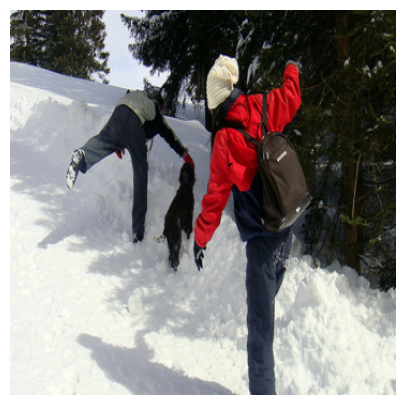

predict: <SOS> a snowboarder in a red jacket is jumping over a snowy hill <EOS>
true: <SOS> two people playing on a snowy hill <EOS>


100%|██████████| 1138/1138 [02:23<00:00,  7.91it/s]

Epoch [22/30], avg train loss: 2.3896



100%|██████████| 114/114 [00:15<00:00,  7.31it/s]

Epoch [22/30], avg valid loss: 2.6186



100%|██████████| 1138/1138 [02:20<00:00,  8.11it/s]

Epoch [23/30], avg train loss: 2.3740



100%|██████████| 114/114 [00:15<00:00,  7.58it/s]

Epoch [23/30], avg valid loss: 2.6307
Early stopping triggered


In [27]:
train_loss_history = []
valid_loss_history = []

for epoch in range(num_epochs):
    # Обучение
    model.train()
    total_train_loss = 0
    for idx, (imgs, ftrs, captions) in tqdm(
        enumerate(train_loader), total=len(train_loader)
    ):
        ftrs = ftrs.to(device)
        captions = captions.to(device)
        # Предсказание модели
        outputs = model(ftrs, captions)
        # Вычисление потерь
        loss = criterion(
            outputs[:-1].reshape(-1, outputs.shape[2]),
            captions.reshape(-1)
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Снимаем значение текущего lr
    # current_lr = scheduler.get_last_lr()[0]
    # Обновление learning rate с помощью планировщика после эпохи
    # scheduler.step()
    # Считаем среднюю ошибку за эпоху
    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)
    print(
        f"Epoch [{epoch+1}/{num_epochs}],",
        f"avg train loss: {avg_train_loss:.4f}"
    ) # f"LR: {current_lr:.9f},"

    # Валидация
    model.eval()
    total_valid_loss = 0
    with torch.no_grad():
        for idx, (imgs, ftrs, captions) in tqdm(
            enumerate(valid_loader), total=len(valid_loader)
        ):
            ftrs = ftrs.to(device)
            captions = captions.to(device)

            # Предсказание модели
            outputs = model(ftrs, captions)
            # Вычисляем ошибку
            loss = criterion(
                outputs[:-1].reshape(-1, outputs.shape[2]),
                captions.reshape(-1)
            )

            total_valid_loss += loss.item()

    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_loss_history.append(avg_valid_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], avg valid loss: {avg_valid_loss:.4f}")

    # Ранняя остановка
    if avg_valid_loss < best_val_loss:
        best_val_loss = avg_valid_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered")
        model.load_state_dict(torch.load('best_model.pth'))
        break

    # Тест
    if (epoch == 0) or ((epoch + 1) % rep_freq == 0):
        print('Inference on test dataset:')
        visualizer(model, test_dataset, device, Flickr_vocab)

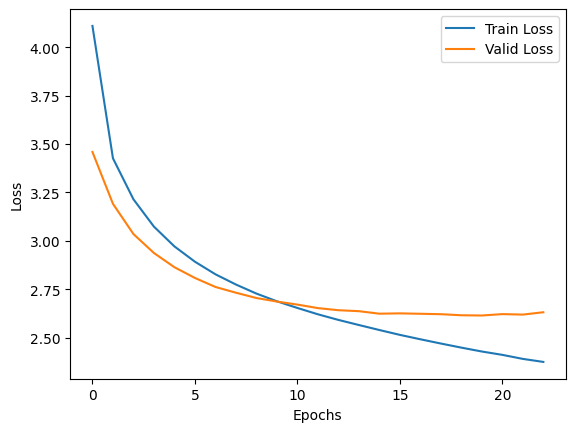

In [28]:
# Визуализация loss-ов:
plt.plot(train_loss_history, label='Train Loss')
plt.plot(valid_loss_history, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **Тестирование модели**

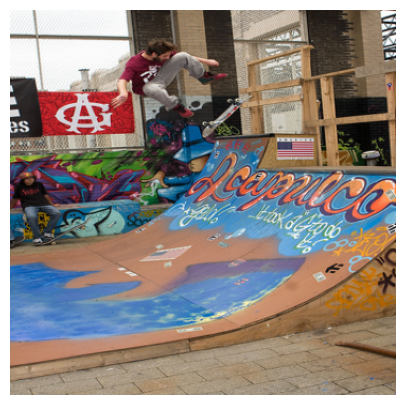

predict: <SOS> a man is riding a skateboard down a <UNK> ramp <EOS>
true: <SOS> man skateboarding off of a ramp <EOS>


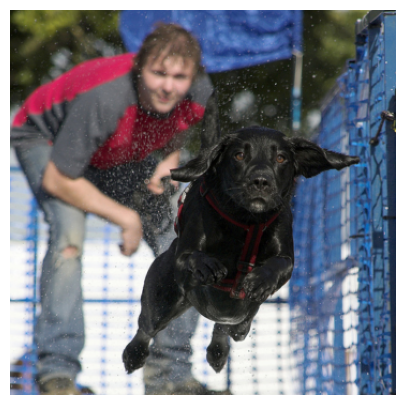

predict: <SOS> a black dog is running through a puddle <EOS>
true: <SOS> a black dog <UNK> up into a pool <EOS>


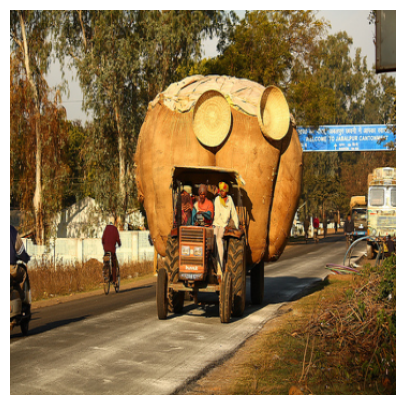

predict: <SOS> a man is riding a horse down a dirt road <EOS>
true: <SOS> several people ride in a very <UNK> looking truck <EOS>


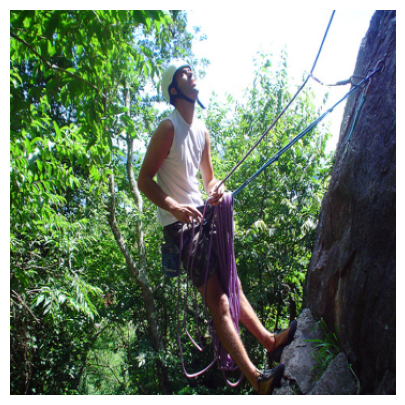

predict: <SOS> a boy in a blue shirt is standing in front of a tree <EOS>
true: <SOS> a young man wearing a white helmet climbing up a rock wall <EOS>


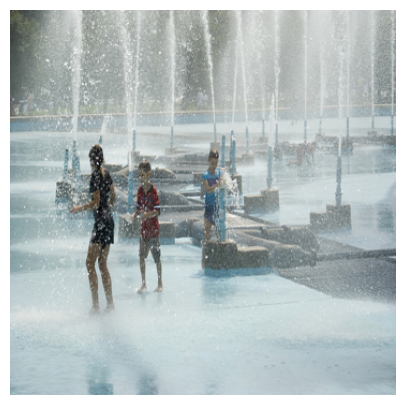

predict: <SOS> a group of people are playing in a water fountain <EOS>
true: <SOS> the three children are playing in a fountain <EOS>


In [29]:
# Можно сколько угодно раз запускать эту ячейку,
# чтобы посмотреть на результаты работы модели с данными из датасета
for _ in range(5):
    visualizer(model, test_dataset, device, Flickr_vocab)

## **Инференс**

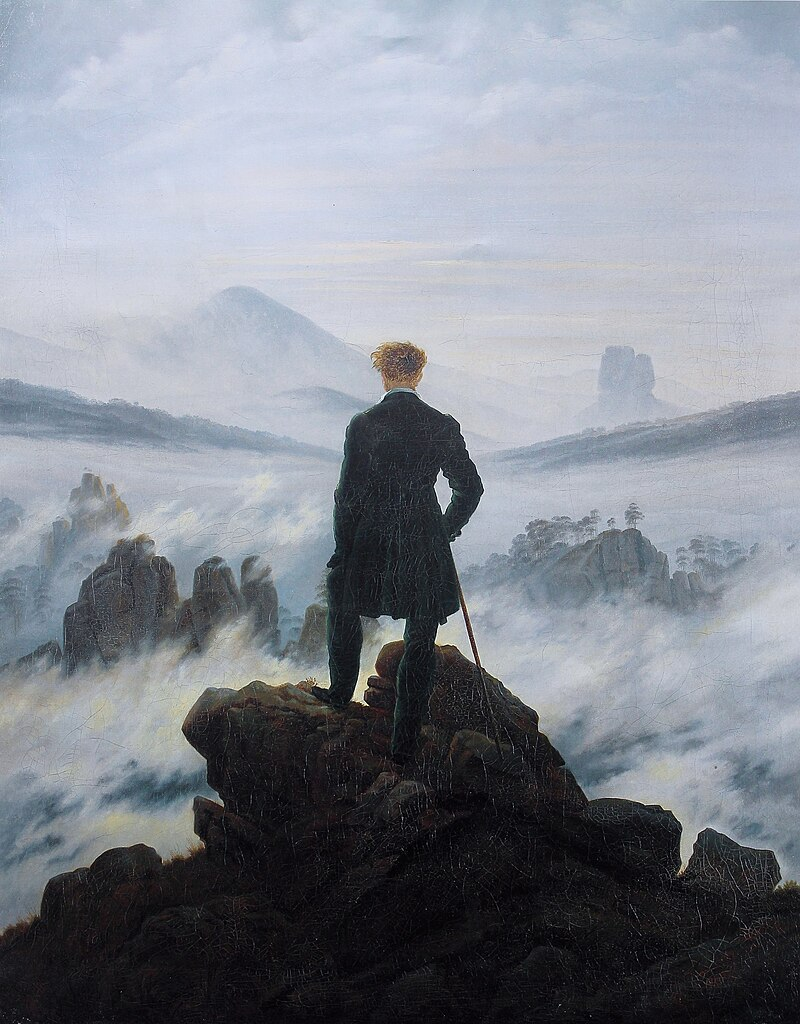

Generated Caption: <SOS> a man in a black jacket is standing on a rocky shore <EOS>


In [34]:
def load_image_from_url(url):
    # Получение изображения по URL
    response = requests.get(url, stream=True)
    response.raise_for_status()
    image = Image.open(response.raw).convert('RGB')
    return image

# URL изображения
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/Caspar_David_Friedrich_-_Wanderer_above_the_sea_of_fog.jpg/800px-Caspar_David_Friedrich_-_Wanderer_above_the_sea_of_fog.jpg'

# Загрузка изображения
image = load_image_from_url(image_url)

# Извлекаем признаки изображения
features = extract_image_features(ftrs_extrctr, image, device)

# Генерируем подпись
caption = model.caption_image(features, train_dataset.vocab)
display(image)
print("Generated Caption:", " ".join(caption))